# Mismatch Kernel / SVM Tutorial
This is an application tutorial of Mismatch String Kernel in package 'strkernel' to Support Vector Machine (SVM) aiming to separate positive and negative sequneces.

In this tutorial we use RNA-Binding protein data (as fasta sequences of the putative binding sites) of proteins IGF2BP123 involved in RNA regulation and known to bind to mRNAs as well as long non-coding RNAs. The original data have been downloaded from the following database http://dorina.mdc-berlin.de, converted to fasta files and pre-processed. Negative or background regions have been generated by taking random genomic regions corresponding to transcribed RNAs, of the same length distribution as the binding site sequences. The data is available in 'notebook_data' directory.

RNA-binding proteins (RBPs) regulate post-transcriptional gene expression and have critical roles in numerous cellular processes including mRNA splicing, export, stability and translation. Despite their ubiquity and importance, the binding preferences for most RBPs are not well characterized. We separate positive and negative sequneces in this tutorial attempting to answer whether RNA-binding protein sites can be discriminated from other RNA regions (or background transcripts) based on sequence alone, and which sequence features are enriched in such binding sites for a particular protein.

First, some python packages are needed to be included, such as self-defined mismatch string kernel, bioinformatics files reading packages and svm related packages.

In [1]:
from mismatch_kernel import MismatchKernel
from mismatch_kernel import preprocess

from Bio import SeqIO
from Bio.Seq import Seq
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report  # classfication summary
import matplotlib.pyplot as plt
import numpy as np
from numpy import random

## Prepare data and preprocessing
As demonstrated above, RBPs data is used in this tutorial. 'Biopython' is a common-used package to read bioinformatics files, for instance, 'fasta' fomat file here. In order to save running time, 2000 positive and negative sequences are randomly opted in our example. The labels of positive sequences are set as 1, negative sequences are set as 0.

In order to use mismatch kernel, sequences are recommended to be preprocessed by calling the function 'preprocess' defined in 'mismatch_kernel'.

In [2]:
# load the data
posSeq = [seq.seq for seq in SeqIO.parse('/notebook_data/positive_IGF2BP123.fasta', 'fasta')]
negSeq = [seq.seq for seq in SeqIO.parse('/notebook_data/negative_IGF2BP123.fasta', 'fasta')]

posX = preprocess(random.choice(posSeq, 2000))
negX = preprocess(random.choice(negSeq, 2000))

# label positive data as 1, negative as 0
posY = np.ones(len(posX), dtype=int)
negY = np.zeros(len(negX), dtype=int)

# compute mismatch kernels used in subsequent SVM training and testing
posKernels = MismatchKernel(l=4, k=5, m=1).get_kernel(posX).kernel
negKernels = MismatchKernel(l=4, k=5, m=1).get_kernel(negX).kernel

# merge data
X = np.concatenate([posKernels,negKernels])
y = np.concatenate([posY,negY])

## How the kernel looks like -- a toy example
Here, I give a toy example to explain how to call the mismatch kernel to compute the kernel and how the mismatch string kernel would look like.

It is obvious that the first two strings in this toy example have high similarity because only the last digits in them are different, so we should expect that similarity estimation of them in the kernel approximately equals to 1, while the estimation between last string and the other two should apparently less than 1.

In 'MismatchKernel' class, we set l=4 since the length of alphabet of the example is 4, just the same as DNA sequences. 'k=3' and 'm=1' present (3,1)-mismatch string kernel, that is, allowing at most 1 mismatch in all 3-mers of sequences.

'leaf_kmers' shows us all mismatch kmers of all sequences and occurence counts of certain kmer in every sequence.

In [3]:
seq = ['ACGTTGA','ACGTTGT','TCACCGT']
int_seq = preprocess(seq)
mismatch_kernel1 = MismatchKernel(l=4, k=3, m=1).get_kernel(int_seq)
mismatch_kernel2 = MismatchKernel(l=4, k=3, m=1).get_kernel(int_seq, normalize = False)
similarity_mat1 = mismatch_kernel1.kernel
similarity_mat2 = mismatch_kernel2.kernel
print(mismatch_kernel1.leaf_kmers)
print(similarity_mat1)
print(similarity_mat2)

{'001': {2: 2}, '002': {0: 1, 1: 1}, '010': {0: 1, 1: 1, 2: 2}, '011': {0: 1, 1: 1, 2: 1}, '012': {0: 1, 1: 1, 2: 2}, '013': {0: 1, 1: 1, 2: 1}, '020': {0: 1}, '021': {2: 1}, '022': {0: 1, 1: 1}, '023': {0: 1, 1: 2, 2: 1}, '031': {2: 1}, '032': {0: 2, 1: 2}, '033': {0: 1, 1: 1}, '100': {2: 1}, '101': {2: 1}, '102': {2: 2}, '103': {0: 1, 1: 1, 2: 2}, '110': {2: 2}, '111': {2: 3}, '112': {0: 1, 1: 1, 2: 1}, '113': {0: 1, 1: 1, 2: 2}, '120': {0: 2, 1: 1, 2: 1}, '121': {0: 1, 1: 1, 2: 2}, '122': {0: 1, 1: 1, 2: 2}, '123': {0: 1, 1: 2, 2: 1}, '131': {2: 1}, '132': {0: 1, 1: 1, 2: 1}, '133': {0: 2, 1: 2, 2: 1}, '201': {2: 1}, '203': {0: 1, 1: 1}, '210': {2: 1}, '211': {2: 1}, '212': {0: 1, 1: 1, 2: 1}, '213': {0: 1, 1: 1}, '220': {0: 1}, '223': {0: 2, 1: 3, 2: 1}, '230': {0: 1, 1: 1}, '231': {0: 1, 1: 1}, '232': {0: 2, 1: 2}, '233': {0: 1, 1: 1}, '300': {0: 1, 2: 1}, '301': {2: 1}, '302': {0: 1, 1: 1}, '303': {1: 1}, '310': {0: 1, 2: 1}, '311': {2: 2}, '312': {0: 2, 1: 2, 2: 2}, '313': {1: 1

As expected, the similarity between the first two strings is arould 1, between last string and the other two is obviously less than 1. In particular, the first kernel matrix is normalized by default and the second one is not by setting the parameter 'normalize' as 'False' in 'get_kernel' function.

## Classification
The processed data in last step can be applied to SVM now, before which we need to split it to training and test data. As what is seen following, 30% is used as test in our case. 

In [4]:
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

clf = SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Result
Now, we can check the training result by some functions provided in 'sklearn' package, for instance, 'classification_report' can produce a classifcation report showing us the precision, recall and f1-score of test data. Finally, we will plot the receiver operating characteristic (ROC) curve and precision recall curve (PRC) to give a more intuitive view.

             precision    recall  f1-score   support

          0       0.84      1.00      0.91       603
          1       1.00      0.80      0.89       597

avg / total       0.92      0.90      0.90      1200



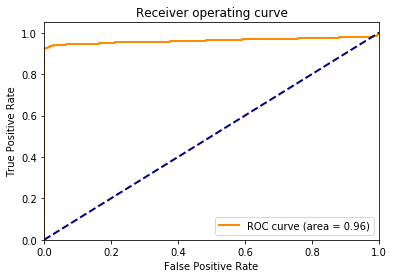

In [5]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

y_score = clf.decision_function(X_test)

'''Plots a roc curve including a baseline'''
# compute true positive rate and false positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)  # compute auc

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating curve')
plt.legend(loc="lower right")
plt.show()

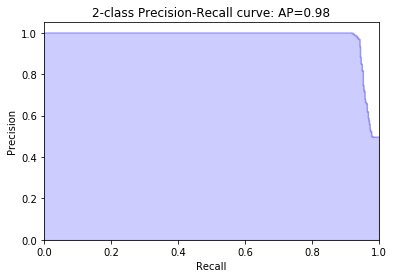

In [6]:
''' Plot precision and recall curve '''
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

As the above result shows, around 84% of the positive and 100% of the negative sequences are successfully seperated. We would say that, in our case, the mismatch kernel used with an SVM classifier performs very well. One can also try different combinations by changing mismatch key values - 'k', 'm' and SVM model parameters, such as 'C', 'kernel' and 'gamma' etc. to check whether the precision would differ much.